In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
# Remote sensing features such as elevation, temperature, humidity, vegetation indices, and fire masks.
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']

In [3]:
def normalize_feature(feature, feature_name):
    """ Normalize features except 'PrevFireMask' """
    if feature_name == 'PrevFireMask':
        return feature
    else:
        return (feature - tf.reduce_mean(feature)) / (tf.math.reduce_std(feature) + 1e-6)

def _parse_function(example_proto):
    """ Parses TFRecord into tensors and normalizes features. 
        This is done so that we can safely use the tensor on Pytorch by porting it from Tensorflow
    """
    feature_description = {feat: tf.io.FixedLenFeature([64, 64], tf.float32) for feat in INPUT_FEATURES + OUTPUT_FEATURES}

    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    inputs_list = [normalize_feature(tf.expand_dims(parsed_example[feat], -1), feat) for feat in INPUT_FEATURES]
    inputs = tf.concat(inputs_list, axis=-1)  # Convert to NumPy

    label = tf.expand_dims(parsed_example['FireMask'], -1)  # Shape: [64, 64, 1]
    label = tf.where(label < 0, 0.0, label)
    label = tf.where(label > 0, 1.0, label)

    return inputs, label

In [4]:
# File Paths from the data directory
train_file = '../data/next_day_wildfire_spread_train*'
validation_file = '../data/next_day_wildfire_spread_eval*'
test_file = '../data/next_day_wildfire_spread_test*'

In [5]:
def get_tensorflow_dataset(file_pattern):
    # Loads the tensor flow tfrecrod from data
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Convert train, validation, and test datasets
train_dataset = get_tensorflow_dataset(train_file)
val_dataset = get_tensorflow_dataset(validation_file)
test_dataset = get_tensorflow_dataset(test_file)

In [6]:
class WildfireDataset(Dataset):
    """
    This data class is used by our Neural Network Models
    """
    def __init__(self, tf_dataset, crop_size=32):
        self.data = list(tf_dataset.as_numpy_iterator()) # Correctly iterate over the dataset
        self.crop_size = crop_size

    def __len__(self):
        """ Return dataset size. """
        return len(self.data)

    def __getitem__(self, idx):
        """ Get a single sample. """
        inputs, label = self.data[idx]
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]
        label = torch.tensor(label, dtype=torch.float32).permute(2, 0, 1)       # [H, W, 1] → [1, H, W] if needed
        return inputs, label

In [7]:
train_dataset = WildfireDataset(train_dataset)
val_dataset = WildfireDataset(val_dataset)
test_dataset = WildfireDataset(test_dataset)

2025-04-24 14:47:13.587162: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-04-24 14:47:15.727982: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-24 14:47:16.006615: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [9]:
TITLES = [
  'Elevation', 'Wind\ndirection', 'Wind\nvelocity', 'Min\ntemp', 'Max\ntemp',
  'Humidity', 'Precip', 'Drought', 'Vegetation', 'Population\ndensity',
  'Energy\nrelease\ncomponent', 'Previous\nfire\nmask', 'Fire\nmask'
]

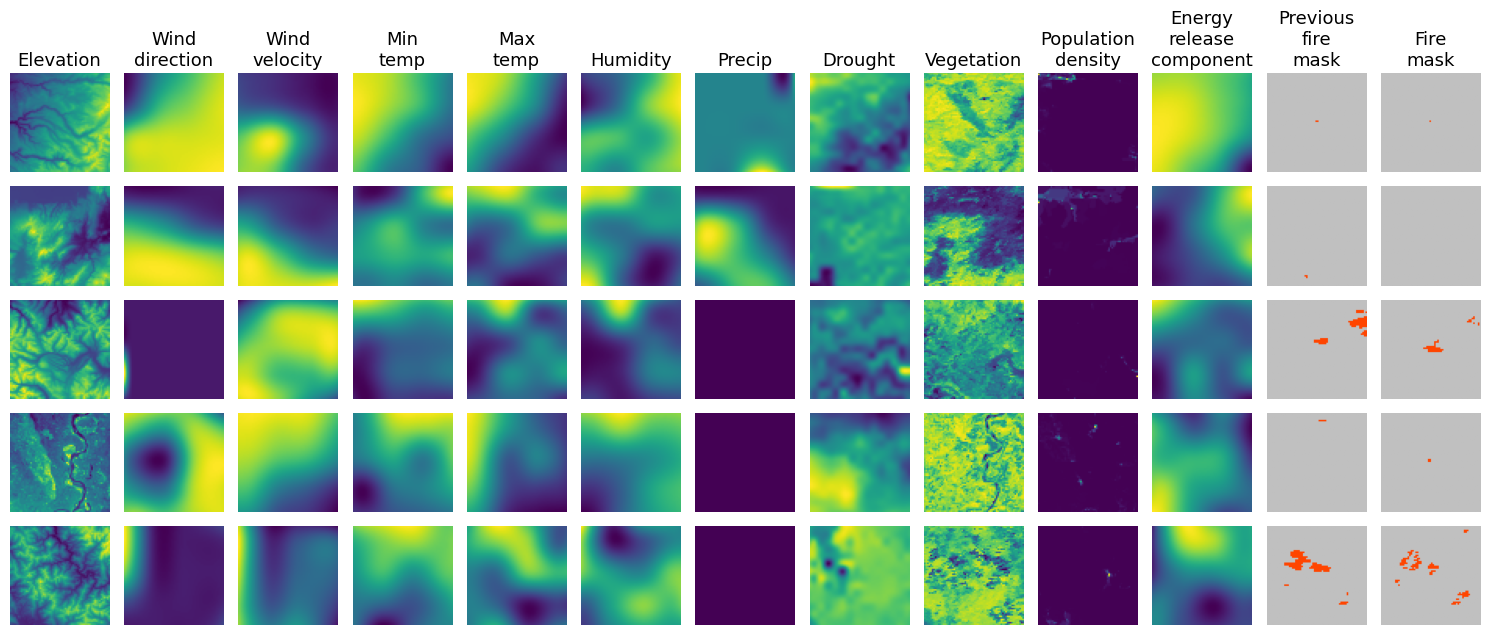

In [10]:
inputs, labels = next(iter(train_loader))

n_rows = 5
n_features = inputs.shape[1]  # [B, C, H, W] → C
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15, 6.5))
for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j < n_features - 1:
            plt.imshow(inputs[i, j].numpy(), cmap='viridis')
        if j == n_features - 1:
            plt.imshow(inputs[i, -1], cmap=CMAP, norm=NORM)
        if j == n_features:
            plt.imshow(labels[i, 0].numpy(), cmap=CMAP, norm=NORM)
        plt.axis('off')
plt.tight_layout()
plt.show()
